# Implementing Improvements To Neural Style Transfer (Github Version)
by Sam Watts 

---



### Neccessary imports
#### Please ensure you have the following files in the same directory: 'vgg.py', 'img_utils.py', 'transformation_network.py', 'training_utils.py'

The **vgg_path** parameter is the name of the file that contains the network weight values of the VGG-19 network pre-trained on ImageNet, as descibed in (Simonyan, K. and Zisserman, A., 2014. Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556.)

These weight values can be found online at: http://www.vlfeat.org/matconvnet/pretrained/ The website states "These models are provided here for convenience, but please credit the original authors". The original paper referenced above has also been referenced in the project report.

In [2]:
import img_utils
import transformation_network
import training_utils
import vgg

import tensorflow as tf
import numpy as np
import functools
from PIL import Image
import datetime
from IPython.display import display
vgg_path = 'imagenet-vgg-verydeep-19.mat'
DIR_PATH = './'

### VGG19 Utility Functions. Defined to make interfacing with the loss network more API friendly.

In [3]:
#Create instance of the VGG19 Loss Network
def get_vgg(image, preprocess=True):
    weights, mean_pixel = vgg.load_net(DIR_PATH+vgg_path)
    if preprocess:
        image = vgg.preprocess(image,mean_pixel)
        
    return vgg.net_preloaded(weights, image, 'avg')
  
#Obtain intermediate activations from a pre-run loss network
def vgg_intermediate_activation(vgg_network, layer):
    return vgg_network[layer]

## The Control Variables
**training_image_names** = Contains list of names of every training content image in directory. You will need to place the folder in the same directory as this file and change the name from 'test2017' to something else if you are not using test2017 from the Microsoft COCO Dataset. 

**style_image_name** = The name of the target style image, contained within the 'images' folder.

**style_image_path** = The path to the location of the target style image. Used if style target is not contained within 'images' folder.

**style_image** = The loaded in style target image as data.

**style layers** = List containing the String names of the target style layers within the VGG19 loss network.

**content_layer** = String variable containing the name of the VGG19 Layer to obtain intermediate activations from for content targets.

**content_weight_** = float value of content loss weight.

**style_weight_** = float value of style loss weight.

**tv_weight_** = Total variation denoise loss weight.

**lap_weights_** = A dictionary with key's representing the average pooling kernel size, and value representing the weight of the laplacian comparison for this kernel size. Number of key value pairs = number of laplacian comparisons.

**learning_rate_** = float value representing learning rate for training.

**epochs_** = Integer value representing number of times the training dataset is iterated over (1 advised).

**norm_** = String value, can support either ''batch' or 'instance'


In [5]:
training_image_names = tf.gfile.ListDirectory(DIR_PATH+ "test2017/")
style_image_name = 'pier.jpg'
style_image_path = 'images/' + style_image_name
style_image = img_utils.load_image(DIR_PATH+style_image_path,resize=False,expand=True)

style_layers = ["relu1_1", "relu2_1", "relu3_1","relu4_1", "relu5_1"]
content_layer = "relu4_3"

content_weight_ = 0.005
style_weight_ = 200
tv_weight_ = 1e-3
lap_weights_ = {4:25, 16:75}

learning_rate_ = 1e-3
epochs_ = 1
norm_ = 'instance'

## The Training Function
This function initialises, trains, and externally saves the Style Transfer network. The parameters control what extensions to include in the network, how to weigh the loss functions, what the neural network training parameters are, etc. The function prints an update of how the network is doing every 500 iterations, this includes current loss values and the image outputs from the minibatch, so the user can evaluate progress and halt early if the direction of training is not as desired.

**training_content** = list of names of every content target training dataset. (pass in style_image_path)

**style_img** = Loaded in style target image. (pass in style_image)

**content_weight** = content loss weight.

**style_weight** = style loss weight.

**tv_weight** = total variation denoise loss weight.

**lap_weights** = dictionary of laplacian kernel size key and comparison weight value. (pass in lap_weights_)

**activation** = TensorFlow activation to be used after convolution blocks. (default tensorflow.nn.relu)

**batch_size** = Minibatch size, how many forward passes are made before updating weights. (default 4)

**norm** = Which normalisation method to use. Can support 'batch' or 'instance'. (default is 'instance')

**learning_rate** = Learning rate to be used during training. (default 0.0001)

**epochs** = How many times to traverse training dataset. (default 1)

**save_name** = What to save the trained model as. If None, defaults to [save_date][style_image_name][save_time]. E.g: "2019-03-19greatwave10-2"

In [9]:
def optimise(training_content,style_img,content_weight,style_weight,tv_weight,lap_weights,
             activation=tf.nn.relu, batch_size=4, norm='instance', 
             learning_rate=0.0001, epochs = 1, save_name=None):
    
    #We store the date and time to make the save file more indentifable and to stop overwriting models during experientation phase
    save_date = str(datetime.date.today())
    save_time = str(datetime.datetime.now().hour) +"-"+ str(datetime.datetime.now().minute)
    if save_name is None or type(save_name) != str:
        save_name = save_date+style_image_name[:-4]+save_time
    
    #Where we contain style Gram matrix targets for each style layer.
    style_targets = {}
    
    #The shape of the style image is arbitrary as gram matricies sizes are C*C and do not depend on height and width
    style_shape = style_img.shape
    #The size of a content image is reduced to 256 to allow for faster training. Once trained, 
    #The input content image can be of any size. (Within memory limitations).
    batch_shape = (batch_size,256,256,3)
    
    with tf.Graph().as_default(), tf.Session() as sess:
        #Initialise VGG for style image.
        style_vgg = get_vgg(tf.cast(style_img,tf.float32))
        print("initialised VGG model for style target..")
        
        #store target gram matricies as a numpy array
        for layer in style_layers:
            style_targets[layer] = training_utils.calcGram(vgg_intermediate_activation(style_vgg,layer)).eval()
            print("Calculated target Gram matrix for layer",layer, "with shape:",style_targets[layer].shape)
    
    with tf.Graph().as_default(), tf.Session() as sess:
        print("STYLE IMAGE SIZE:",style_img.shape,"\n")
        
        #Data placeholder        
        batch_data = tf.placeholder(tf.float32, shape=(batch_size,256,256,3), name='batch_data')
        print("Created batch_data placeholder..")
        
        #Initialise VGG for content target and store activations from desired hidden layer.        
        content_vgg =get_vgg(batch_data)
        print("Initialised VGG model for content target..")
        content_target = vgg_intermediate_activation(content_vgg, content_layer)
        print("Content target for layer",content_layer,"is stored.\n")
        
        #Initialise transformation network with batch images. 
        stylised = transformation_network.get_network(batch_data/255, norm_ = norm)
        print("Transformation network to train has been created.")
        
        #VGG for stylised images in the batch.
        generated_vgg = get_vgg(stylised)
        print("Initialised VGG model for stylised target..\n")
        
        #Calculate content loss as squared difference of generated img activations
        #and target image activations at the chosen content layer of VGG19
        content_loss = content_weight * training_utils.calc_squared_loss(
            vgg_intermediate_activation(generated_vgg,content_layer), 
            content_target) / batch_size        
        print("Content loss formula defined.")
        
        #We store each gram matrix from the target layers in this variable.
        style_losses = []

        for layer in style_layers:
            activations = vgg_intermediate_activation(generated_vgg,layer) #Get activations from VGG19 of generated image for layer
            gram = training_utils.calcGram(activations) #Calculate the gram matrix
            style_loss_ = training_utils.calc_squared_loss(gram, style_targets[layer], normalize=False)
            style_losses.append(style_loss_)
            
        #We then add all the individual layer loss values together and multiply it by style weight.
        style_loss = style_weight * functools.reduce(tf.add, style_losses) / batch_size
        
        print("Style loss formula defined.")
        
        #Calculate TV loss by using tensorflow's implementation of total variation, multiplied by tv weight.
        total_variation_denoise_loss = tv_weight * tf.reduce_sum(tf.image.total_variation(stylised)) /batch_size
        print("Total variation loss formula defined.")
        
        
        lap_loss = 0
        #The laplacian loss is calculated by comparing the laplacians of the content target image
        #With the laplacian of the transformed image, at different pooling sizes.
        for pool,weight in lap_weights.items():
            lap_loss += weight * training_utils.calc_squared_loss(training_utils.get_laplacian_img(batch_data,pool),
                                                                          training_utils.get_laplacian_img(stylised,pool),
                                                                          normalize=False)
        lap_loss /= batch_size
        
        #Total loss is the sum of all individual loss functions.
        total_loss = content_loss + style_loss + total_variation_denoise_loss + lap_loss
        
        #AdamOptimizer to train our network, with the loss function we defined above.
        trainer = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)
        print("Trainer initialised.")
        
        #Global variable initialiser is required to initalise all tensorflow.Variable objects.
        sess.run(tf.global_variables_initializer())
        print("Global Variables Initialised.")
        
        #The network saver is initialised.
        saver = tf.train.Saver()
             
        print("entering training..")

        best_score = 0
        total_iterations = 0
               
        for epoch in range(0,epochs,1): # For each epoch..
            iterations = 0
            #While we have not reached the end of the training image dataset..
            while iterations * batch_size  < len(training_content):

              #begin and stop capture the start and finish indices of the training dataset.
                begin = iterations * batch_size
                stop = begin + batch_size

              #The train batch is initialised as a 4D array of same shape as the batch to deliver.
                train_batch = np.zeros(batch_shape,dtype=np.float32)

              #For each image in the minibatch..
                for i, img in enumerate(training_content[begin:stop]):
                    if (img == "Thumbs.db"): #Occaisionally this file is present in the dataset, and it is not required.
                        temp = np.zeros(batch_shape[1:],dtype=np.float32) #Replace for blank image.
                    else:
                        temp = img_utils.load_image(DIR_PATH+"test2017/"+img,expand=False)

                    if (temp.shape != batch_shape[1:]): #if the loaded image isn't of RGB format,
                        temp = img_utils.gray_to_rgb(temp) #it is converted to rgb.
                    train_batch[i] = temp

                feed_dict = {batch_data:train_batch}

              #execute the next iteration of the trainer with the minibatch.
                trainer.run(feed_dict = feed_dict)
              #Retrieve the current iteration's loss values.
                tot_loss,c_loss,s_loss,tv_loss,l_loss,predictions = sess.run([total_loss,content_loss,style_loss,
                                                                            total_variation_denoise_loss, lap_loss, stylised],
                                                                           feed_dict=feed_dict)
              #If the total loss is the new best lowest, we save this model.
                if ((iterations == 0 and epoch == 0) or best_score >= tot_loss ) :
                    best_score = tot_loss
                    saver.save(sess,DIR_PATH+"MODELS/"+save_name+"/model",write_meta_graph=False )
              
              #continuously return the loss values and output at each iteration.
                yield(total_iterations,epoch,tot_loss,c_loss,s_loss,tv_loss,l_loss, predictions)

                iterations += 1
                total_iterations += 1

            

### Training a Network Command
#### I would recommend running on a GPU for much faster training times. (Or use Google Colab)

In [ ]:
print("TARGET STYLE:\n")
display(Image.fromarray(np.squeeze(style_image).astype(np.uint8)))

for iter_,epoch_,loss_t, loss_c,loss_s,loss_tv,loss_l,preds_ in optimise(training_image_names,style_image,content_weight_,
                                                                          style_weight_,tv_weight_,lap_weights_, norm=norm_,
                                                                          learning_rate=learning_rate_, epochs=epochs_):
    if (iter_ % 500 == 0): 
        print("\nITERATION: ",iter_)
        print("EPOCH: ",epoch_)
        print("TOTAL LOSS: ",loss_t)
        print("CONTENT LOSS: ",loss_c)
        print("STYLE LOSS: ",loss_s)
        print("VARIATION LOSS: ", loss_tv)
        print("LAPLACIAN LOSS: ", loss_l)

        preds_ = np.clip(preds_,0,255).astype(np.uint8)
        for i in range(0,preds_.shape[0],1):

            display(Image.fromarray(preds_[i]))


## The Image Stylisation Function
Trained networks can be used to transform any given image of reasonable size. This function takes one image at a time, and allows the user to control what pre-trained network to use, and whether to resize the image down or up before transformation. The result is a PIL Image object.

**image_name** = String path to the input image.

**model_name** = String path to the transformation network.

**size** = Can be an Integer, in which case the image is scaled down by a factor equal to that of 'size' before stylisation. Also can be a Tuple of size 2 Integers, which gives exact pixel size for the image to be resized to. If false, no resize.

**norm** = has to be either 'instance' or 'batch', depending on how the transformation network to be used has it's architecture.

In [10]:
 def stylise_image(image_name, model_name, size = False, norm='instance'):
    graph = tf.Graph()
    input_image = img_utils.load_image(image_name, resize=False)
    _,x,y,_ = input_image.shape
  
    resized=False
  
    if (size != False):
        if isinstance(size,tuple):
            input_image = Image.fromarray(input_image[0].astype(np.uint8))
            input_image = input_image.resize(size)
            input_image = np.expand_dims(np.array(input_image),0)/255
            resized = True
        if isinstance(size,int):
            input_image = Image.fromarray(input_image[0].astype(np.uint8))
            new_shape =  [int(y/size), int(x/size)]
            input_image = input_image.resize(new_shape)
            input_image = np.expand_dims(np.array(input_image),0)/255
            resized = True
  
    elif (x > 2200 or y > 2200) :
        input_image = Image.fromarray(input_image[0].astype(np.uint8))
        new_shape =  [int(y/2), int(x/2)]
        input_image = input_image.resize(new_shape)
        input_image = np.expand_dims(np.array(input_image),0)/255
        resized = True
        
    with graph.as_default():
        input_image = input_image/255
        input_placeholder = tf.placeholder(shape=input_image.shape,dtype=tf.float32)
        net = transformation_network.get_network(input_placeholder,norm_=norm)
        saver = tf.train.Saver()
    with tf.Session(graph=graph) as sess:
        saver.restore(sess, model_name)

        prediction = sess.run(net , feed_dict={input_placeholder:input_image})
        prediction = np.clip(prediction,0,255)[0]
        img = Image.fromarray(prediction.astype(np.uint8))

    return img
 


#### The input image to transform is 'test_img_name'

In [12]:
test_img_name = 'pier'
test_img_path = DIR_PATH+"images/" + test_img_name + ".jpg" 
style_network_path = "MODELS/" + "___" #Replace ___ for model directory.

INFO:tensorflow:Restoring parameters from ./Pretrained_Models/starrynight_lap_instance/model


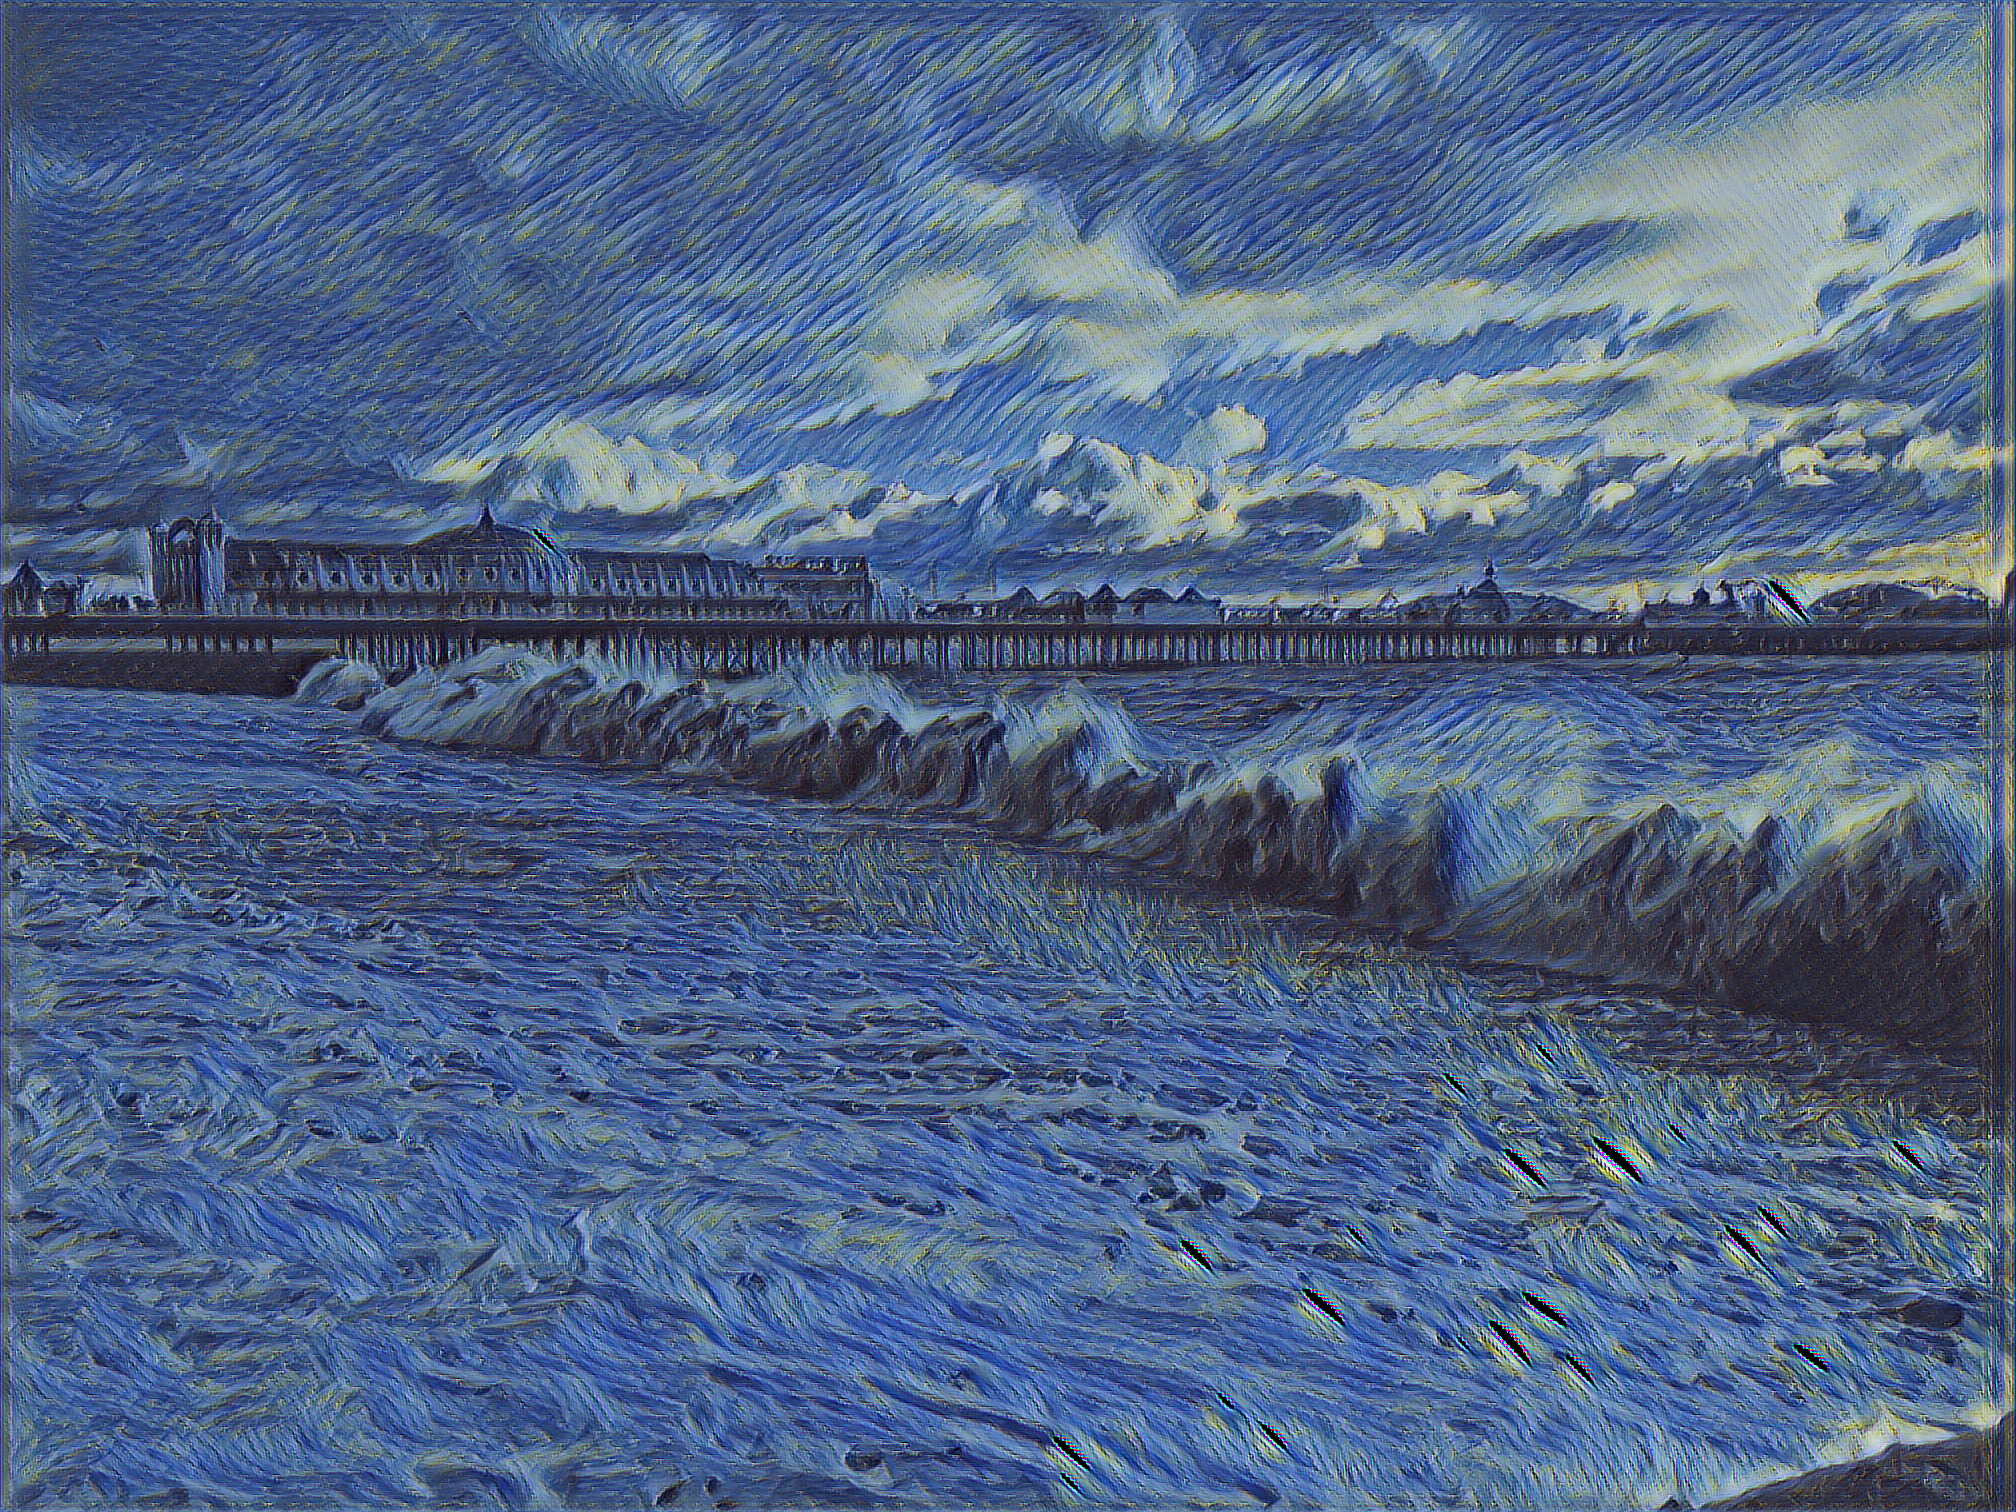

In [18]:
#Displays to the kernel the stylised image.